# Feature Engineering + Conventional ML

**Approach**: Hand-crafted features from CV history + Random Forest

This approach engineers features from **full CV history** and trains Random Forest classifiers:
1. Load unannotated CVs with full career history
2. Match job titles to lookup tables (department-v2.csv, seniority-v2.csv) for labels
3. Extract career features:
   - Number of previous positions
   - Career progression indicators (seniority keywords)
   - Department indicators (domain keywords)
   - Text features from current job title (TF-IDF)
4. Train Random Forest on unannotated data with lookup-based labels
5. Validate on annotated dataset

**Training Data**: Unannotated LinkedIn CVs + Lookup table labels  
**Validation Data**: Annotated LinkedIn CVs

In [5]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

# Import data loaders
import sys
sys.path.append('../')
from src.data.loader import load_linkedin_data, load_label_lists, prepare_dataset, load_evaluation_dataset

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
MODELS_DIR = Path('../models')
RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

%matplotlib inline

## 1. Load Data

Load unannotated CVs for training and annotated CVs for validation.

In [6]:
# Load unannotated data with full career history
unannotated_cvs = load_linkedin_data(str(DATA_DIR / 'linkedin-cvs-not-annotated.json'))

# Prepare dataset with history
def prepare_dataset_with_history(cvs):
    """Prepare dataset with career history features."""
    records = []
    
    for cv_idx, cv in enumerate(cvs):
        positions = cv if isinstance(cv, list) else cv.get('positions', [])
        
        active_positions = [p for p in positions if p.get('status') == 'ACTIVE']
        if not active_positions:
            continue
            
        active = active_positions[0]
        title = active.get('position', active.get('title', ''))
        company = active.get('organization', active.get('companyName', ''))
        
        # Count previous jobs
        past_positions = [p for p in positions if p.get('status') != 'ACTIVE']
        num_previous_jobs = len(past_positions)
        
        record = {
            'cv_id': cv_idx,
            'title': title,
            'company': company,
            'text': f"{title} at {company}".strip() if company else title,
            'num_previous_jobs': num_previous_jobs,
            'total_positions': len(positions)
        }
        records.append(record)
    
    return pd.DataFrame(records)

train_df = prepare_dataset_with_history(unannotated_cvs)
print(f"📊 Loaded {len(train_df)} unannotated CV positions for training")
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nSample data:")
train_df.head()

📊 Loaded 314 unannotated CV positions for training

Columns: ['cv_id', 'title', 'company', 'text', 'num_previous_jobs', 'total_positions']

Sample data:


,cv_id,title,company,text,num_previous_jobs,total_positions
0,0,Bookkeeper,"Keeping The Books, Bookkeeping","Bookkeeper at Keeping The Books, Bookkeeping",6,8
1,1,Strategy & Investments,Erste Bank und Sparkasse,Strategy & Investments at Erste Bank und Spark...,12,13
2,2,Corporate Auditor,Guido Meyer,Corporate Auditor at Guido Meyer,0,2
3,4,Marketing Manager,Tradeware AG,Marketing Manager at Tradeware AG,7,8
4,5,Professor,Monash University,Professor at Monash University,7,10


In [7]:
# Load validation data (annotated)
val_df = load_evaluation_dataset(DATA_DIR)
print(f"📊 Loaded {len(val_df)} annotated CV positions for validation")
print(f"\nColumns: {list(val_df.columns)}")
val_df.head()

📊 Loaded 478 annotated CV positions for validation

Columns: ['cv_id', 'title', 'company', 'text', 'department', 'seniority']


,cv_id,title,company,text,department,seniority
0,0,Prokurist,Depot4Design GmbH,Prokurist at Depot4Design GmbH,Other,Management
1,1,Solutions Architect,Computer Solutions,Solutions Architect at Computer Solutions,Information Technology,Professional
2,2,Medizintechnik Beratung,Udo Weber,Medizintechnik Beratung at Udo Weber,Consulting,Professional
3,3,Director expansión de negocio.,Grupo Viajes Kontiki.,Director expansión de negocio. at Grupo Viajes...,Business Development,Director
4,4,"APL-ansvarig, samordning",Himmelstalunds Utbildningscentrum,"APL-ansvarig, samordning at Himmelstalunds Utb...",Administrative,Lead


## 2. Label Training Data Using Lookup Tables

Use fuzzy matching to assign labels from department-v2.csv and seniority-v2.csv.

In [8]:
from fuzzywuzzy import process, fuzz

# Load lookup tables
dept_df, sen_df = load_label_lists(DATA_DIR)

print(f"Department lookup: {len(dept_df)} entries, {dept_df['label'].nunique()} unique labels")
print(f"Seniority lookup: {len(sen_df)} entries, {sen_df['label'].nunique()} unique labels")

# Create lookup dictionaries
dept_lookup = dict(zip(dept_df['text'].str.lower(), dept_df['label']))
sen_lookup = dict(zip(sen_df['text'].str.lower(), sen_df['label']))

c:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Department lookup: 10145 entries, 11 unique labels
Seniority lookup: 9428 entries, 5 unique labels


In [9]:
def fuzzy_match_label(title, lookup_dict, threshold=80):
    """
    Match a job title to lookup table using fuzzy matching.
    
    Args:
        title: Job title to match
        lookup_dict: Dictionary mapping text to labels
        threshold: Minimum fuzzy match score (0-100)
    
    Returns:
        Matched label or None
    """
    if not title or pd.isna(title):
        return None
    
    title_lower = title.lower()
    
    # Try exact match first
    if title_lower in lookup_dict:
        return lookup_dict[title_lower]
    
    # Fuzzy match
    match = process.extractOne(title_lower, lookup_dict.keys(), scorer=fuzz.token_sort_ratio)
    
    if match and match[1] >= threshold:
        return lookup_dict[match[0]]
    
    return None

# Apply fuzzy matching to training data
print("Matching training titles to lookup tables...")
train_df['department'] = train_df['title'].apply(lambda x: fuzzy_match_label(x, dept_lookup))
train_df['seniority'] = train_df['title'].apply(lambda x: fuzzy_match_label(x, sen_lookup))

# Check coverage
dept_coverage = (~train_df['department'].isna()).sum() / len(train_df) * 100
sen_coverage = (~train_df['seniority'].isna()).sum() / len(train_df) * 100

print(f"\n✅ Label coverage on training data:")
print(f"  Department: {dept_coverage:.1f}% ({(~train_df['department'].isna()).sum()}/{len(train_df)})")
print(f"  Seniority:  {sen_coverage:.1f}% ({(~train_df['seniority'].isna()).sum()}/{len(train_df)})")

print(f"\n📊 Label distributions:")
print(f"\nDepartment:")
print(train_df['department'].value_counts())
print(f"\nSeniority:")
print(train_df['seniority'].value_counts())

Matching training titles to lookup tables...

✅ Label coverage on training data:
  Department: 30.9% (97/314)
  Seniority:  46.5% (146/314)

📊 Label distributions:

Department:
department
Sales                     31
Information Technology    25
Marketing                 11
Project Management         9
Business Development       6
Consulting                 5
Human Resources            4
Purchasing                 3
Other                      2
Administrative             1
Name: count, dtype: int64

Seniority:
seniority
Senior        67
Management    46
Director      20
Lead           9
Junior         4
Name: count, dtype: int64


## 3. Engineer Career Features

Extract features from CV history and job titles.

In [10]:
def extract_career_features(df):
    """
    Extract career progression features from CV data.
    """
    features = pd.DataFrame()
    
    # Career history features
    features['num_previous_jobs'] = df['num_previous_jobs']
    features['total_positions'] = df['total_positions']
    
    # Text-based features from current title
    features['title_length'] = df['title'].str.len()
    features['title_word_count'] = df['title'].str.split().str.len()
    
    # Seniority indicators in title (heuristic)
    senior_keywords = ['senior', 'lead', 'principal', 'chief', 'director', 'head', 'vp', 'vice president', 'manager']
    junior_keywords = ['junior', 'trainee', 'intern', 'assistant', 'associate', 'entry']
    
    features['has_senior_keyword'] = df['title'].str.lower().apply(
        lambda x: int(any(kw in x for kw in senior_keywords)) if pd.notna(x) else 0
    )
    features['has_junior_keyword'] = df['title'].str.lower().apply(
        lambda x: int(any(kw in x for kw in junior_keywords)) if pd.notna(x) else 0
    )
    
    # Department indicators in title (heuristic)
    dept_keywords = {
        'it': ['developer', 'engineer', 'programmer', 'software', 'data', 'it', 'tech', 'system'],
        'marketing': ['marketing', 'brand', 'content', 'social media', 'campaign'],
        'sales': ['sales', 'account', 'business development', 'revenue'],
        'hr': ['hr', 'human resources', 'recruitment', 'talent', 'people'],
        'finance': ['finance', 'accounting', 'controller', 'cfo', 'audit']
    }
    
    for dept, keywords in dept_keywords.items():
        features[f'dept_kw_{dept}'] = df['title'].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords)) if pd.notna(x) else 0
        )
    
    return features

# Extract features for training data
train_career_features = extract_career_features(train_df)
print(f"Extracted {train_career_features.shape[1]} career features for training data")
print(f"\nFeature statistics:")
print(train_career_features.describe())

Extracted 11 career features for training data

Feature statistics:
       num_previous_jobs  total_positions  title_length  title_word_count  \
count         314.000000       314.000000    314.000000        314.000000   
mean            4.171975         5.506369     24.009554          2.952229   
std             3.592997         3.665959     14.655683          2.035063   
min             0.000000         1.000000      3.000000          1.000000   
25%             1.000000         3.000000     15.000000          2.000000   
50%             4.000000         5.000000     20.000000          2.000000   
75%             7.000000         8.000000     30.000000          4.000000   
max            17.000000        20.000000     91.000000         12.000000   

       has_senior_keyword  has_junior_keyword  dept_kw_it  dept_kw_marketing  \
count          314.000000          314.000000  314.000000         314.000000   
mean             0.401274            0.019108    0.257962           0.035032  

## 4. Extract TF-IDF Features from Job Titles

In [11]:
# Create TF-IDF vectorizer on training data
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    lowercase=True,
    min_df=2
)

# Fit on training titles
train_tfidf_features = tfidf_vectorizer.fit_transform(train_df['title'].fillna(''))

print(f"TF-IDF features: {train_tfidf_features.shape[1]}")
print(f"Total feature vector size: {train_career_features.shape[1]} (career) + {train_tfidf_features.shape[1]} (text)")

TF-IDF features: 159
Total feature vector size: 11 (career) + 159 (text)


## 5. Combine Features

In [12]:
# Combine career features (dense) with TF-IDF features (sparse)
train_combined_features = hstack([
    train_career_features.values,
    train_tfidf_features
]).tocsr()  # Convert to CSR for efficient indexing

print(f"Combined training feature matrix shape: {train_combined_features.shape}")
print(f"  Career features: {train_career_features.shape[1]}")
print(f"  TF-IDF features: {train_tfidf_features.shape[1]}")
print(f"  Total: {train_combined_features.shape[1]}")

Combined training feature matrix shape: (314, 170)
  Career features: 11
  TF-IDF features: 159
  Total: 170


## 6. Prepare Training Sets

Filter training data to only include samples with labels.

In [13]:
# Department training set
dept_train_indices = ~train_df['department'].isna()
dept_X_train = train_combined_features[dept_train_indices.values]
dept_y_train = train_df.loc[dept_train_indices, 'department'].tolist()

print(f"Department training set: {dept_X_train.shape[0]} samples")
print(f"  Classes: {len(set(dept_y_train))}")

# Seniority training set
sen_train_indices = ~train_df['seniority'].isna()
sen_X_train = train_combined_features[sen_train_indices.values]
sen_y_train = train_df.loc[sen_train_indices, 'seniority'].tolist()

print(f"\nSeniority training set: {sen_X_train.shape[0]} samples")
print(f"  Classes: {len(set(sen_y_train))}")

Department training set: 97 samples
  Classes: 10

Seniority training set: 146 samples
  Classes: 5


## 7. Train Random Forest Classifiers

In [14]:
# Department Random Forest
print("Training Department Random Forest...")

dept_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

dept_rf.fit(dept_X_train, dept_y_train)
print("✅ Department model trained")

Training Department Random Forest...
✅ Department model trained


In [15]:
# Seniority Random Forest
print("Training Seniority Random Forest...")

sen_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

sen_rf.fit(sen_X_train, sen_y_train)
print("✅ Seniority model trained")

Training Seniority Random Forest...
✅ Seniority model trained


## 8. Prepare Validation Data

Extract same features from validation data.

In [16]:
# Add career history features to validation data
# Note: Validation data doesn't have num_previous_jobs, so we'll use 0 as default
# This is a limitation - ideally we'd load validation data with history too
val_df['num_previous_jobs'] = 0  # Default value
val_df['total_positions'] = 1   # Default value

# Extract career features for validation
val_career_features = extract_career_features(val_df)

# Extract TF-IDF features using fitted vectorizer
val_tfidf_features = tfidf_vectorizer.transform(val_df['title'].fillna(''))

# Combine features
val_combined_features = hstack([
    val_career_features.values,
    val_tfidf_features
]).tocsr()

print(f"Validation feature matrix shape: {val_combined_features.shape}")

Validation feature matrix shape: (478, 170)


## 9. Evaluate on Validation Data

In [17]:
# Department validation
dept_val_indices = ~val_df['department'].isna()
dept_X_val = val_combined_features[dept_val_indices.values]
dept_y_val = val_df.loc[dept_val_indices, 'department'].tolist()

# Predict
dept_predictions = dept_rf.predict(dept_X_val)

# Calculate metrics
dept_accuracy = accuracy_score(dept_y_val, dept_predictions)
dept_precision, dept_recall, dept_f1, _ = precision_recall_fscore_support(
    dept_y_val, dept_predictions, average='macro', zero_division=0
)
dept_weighted_f1 = precision_recall_fscore_support(
    dept_y_val, dept_predictions, average='weighted', zero_division=0
)[2]

print("="*60)
print("DEPARTMENT CLASSIFICATION RESULTS")
print("="*60)
print(f"Validation samples: {len(dept_y_val)}")
print(f"Accuracy:          {dept_accuracy:.4f}")
print(f"Precision (macro): {dept_precision:.4f}")
print(f"Recall (macro):    {dept_recall:.4f}")
print(f"F1-score (macro):  {dept_f1:.4f}")
print(f"F1-score (wtd):    {dept_weighted_f1:.4f}")
print("="*60)

DEPARTMENT CLASSIFICATION RESULTS
Validation samples: 478
Accuracy:          0.1695
Precision (macro): 0.2276
Recall (macro):    0.1876
F1-score (macro):  0.1425
F1-score (wtd):    0.0939


In [18]:
# Seniority validation
sen_val_indices = ~val_df['seniority'].isna()
sen_X_val = val_combined_features[sen_val_indices.values]
sen_y_val = val_df.loc[sen_val_indices, 'seniority'].tolist()

# Predict
sen_predictions = sen_rf.predict(sen_X_val)

# Calculate metrics
sen_accuracy = accuracy_score(sen_y_val, sen_predictions)
sen_precision, sen_recall, sen_f1, _ = precision_recall_fscore_support(
    sen_y_val, sen_predictions, average='macro', zero_division=0
)
sen_weighted_f1 = precision_recall_fscore_support(
    sen_y_val, sen_predictions, average='weighted', zero_division=0
)[2]

print("="*60)
print("SENIORITY CLASSIFICATION RESULTS")
print("="*60)
print(f"Validation samples: {len(sen_y_val)}")
print(f"Accuracy:          {sen_accuracy:.4f}")
print(f"Precision (macro): {sen_precision:.4f}")
print(f"Recall (macro):    {sen_recall:.4f}")
print(f"F1-score (macro):  {sen_f1:.4f}")
print(f"F1-score (wtd):    {sen_weighted_f1:.4f}")
print("="*60)

SENIORITY CLASSIFICATION RESULTS
Validation samples: 478
Accuracy:          0.3285
Precision (macro): 0.1903
Recall (macro):    0.4019
F1-score (macro):  0.2498
F1-score (wtd):    0.2064


## 10. Feature Importance Analysis

In [19]:
# Get feature names
career_feature_names = train_career_features.columns.tolist()
tfidf_feature_names = [f"tfidf_{name}" for name in tfidf_vectorizer.get_feature_names_out()]
all_feature_names = career_feature_names + tfidf_feature_names

# Department feature importance
dept_importances = dept_rf.feature_importances_
dept_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': dept_importances
}).sort_values('importance', ascending=False)

print("Top 20 features for Department classification:\n")
for idx, row in dept_importance_df.head(20).iterrows():
    print(f"  {row['feature']:<50} {row['importance']:.4f}")

Top 20 features for Department classification:

  title_length                                       0.0900
  tfidf_marketing                                    0.0826
  tfidf_manager                                      0.0714
  dept_kw_marketing                                  0.0692
  tfidf_senior                                       0.0655
  total_positions                                    0.0496
  tfidf_consultant                                   0.0456
  title_word_count                                   0.0454
  tfidf_business                                     0.0429
  tfidf_project                                      0.0371
  num_previous_jobs                                  0.0370
  tfidf_senior manager                               0.0271
  tfidf_director                                     0.0269
  tfidf_human                                        0.0244
  tfidf_project manager                              0.0223
  tfidf_sales                                       

In [20]:
# Seniority feature importance
sen_importances = sen_rf.feature_importances_
sen_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': sen_importances
}).sort_values('importance', ascending=False)

print("Top 20 features for Seniority classification:\n")
for idx, row in sen_importance_df.head(20).iterrows():
    print(f"  {row['feature']:<50} {row['importance']:.4f}")

Top 20 features for Seniority classification:

  tfidf_director                                     0.1788
  tfidf_manager                                      0.1266
  has_senior_keyword                                 0.1012
  title_word_count                                   0.0570
  title_length                                       0.0554
  num_previous_jobs                                  0.0437
  tfidf_chief                                        0.0418
  tfidf_ceo                                          0.0380
  dept_kw_hr                                         0.0323
  total_positions                                    0.0291
  tfidf_managing director                            0.0253
  tfidf_officer                                      0.0244
  dept_kw_it                                         0.0232
  tfidf_managing                                     0.0224
  tfidf_senior                                       0.0215
  tfidf_geschäftsführer                              

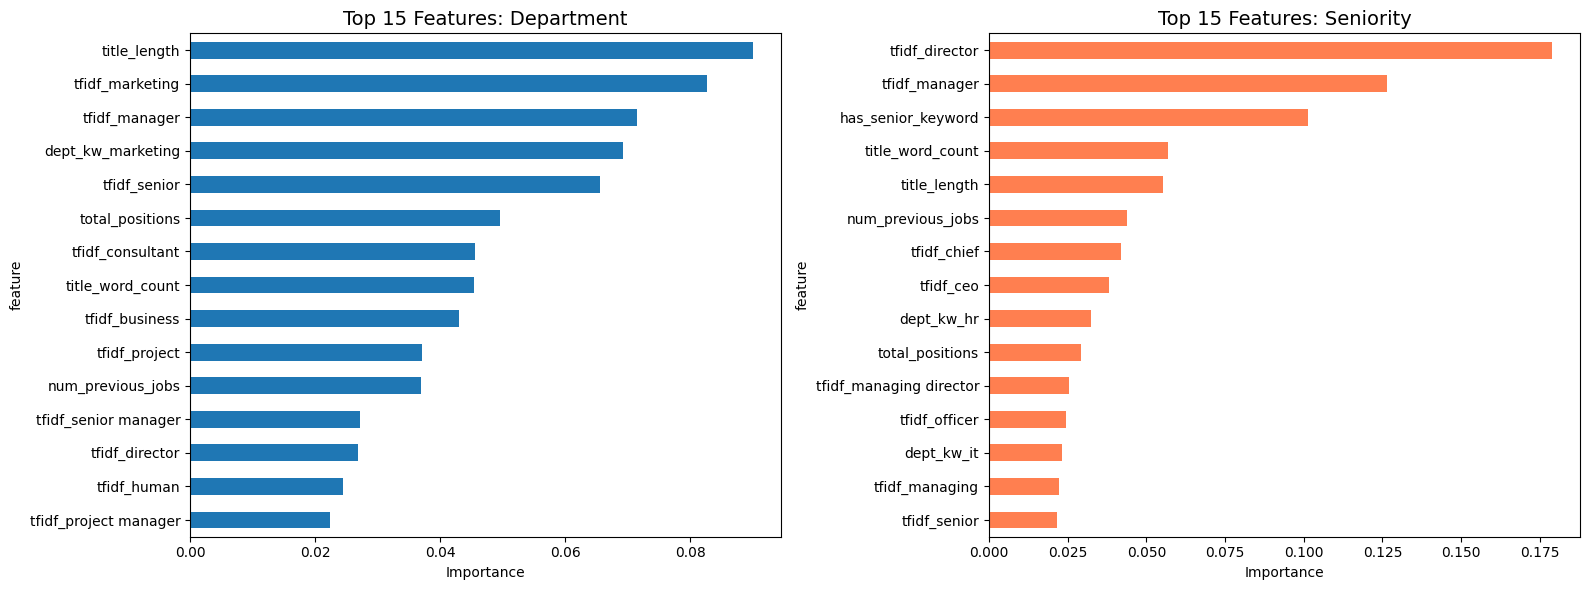

In [21]:
# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Department
dept_importance_df.head(15).plot(x='feature', y='importance', kind='barh', ax=axes[0], legend=False)
axes[0].set_title('Top 15 Features: Department', fontsize=14)
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()

# Seniority
sen_importance_df.head(15).plot(x='feature', y='importance', kind='barh', ax=axes[1], legend=False, color='coral')
axes[1].set_title('Top 15 Features: Seniority', fontsize=14)
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 11. Confusion Matrices

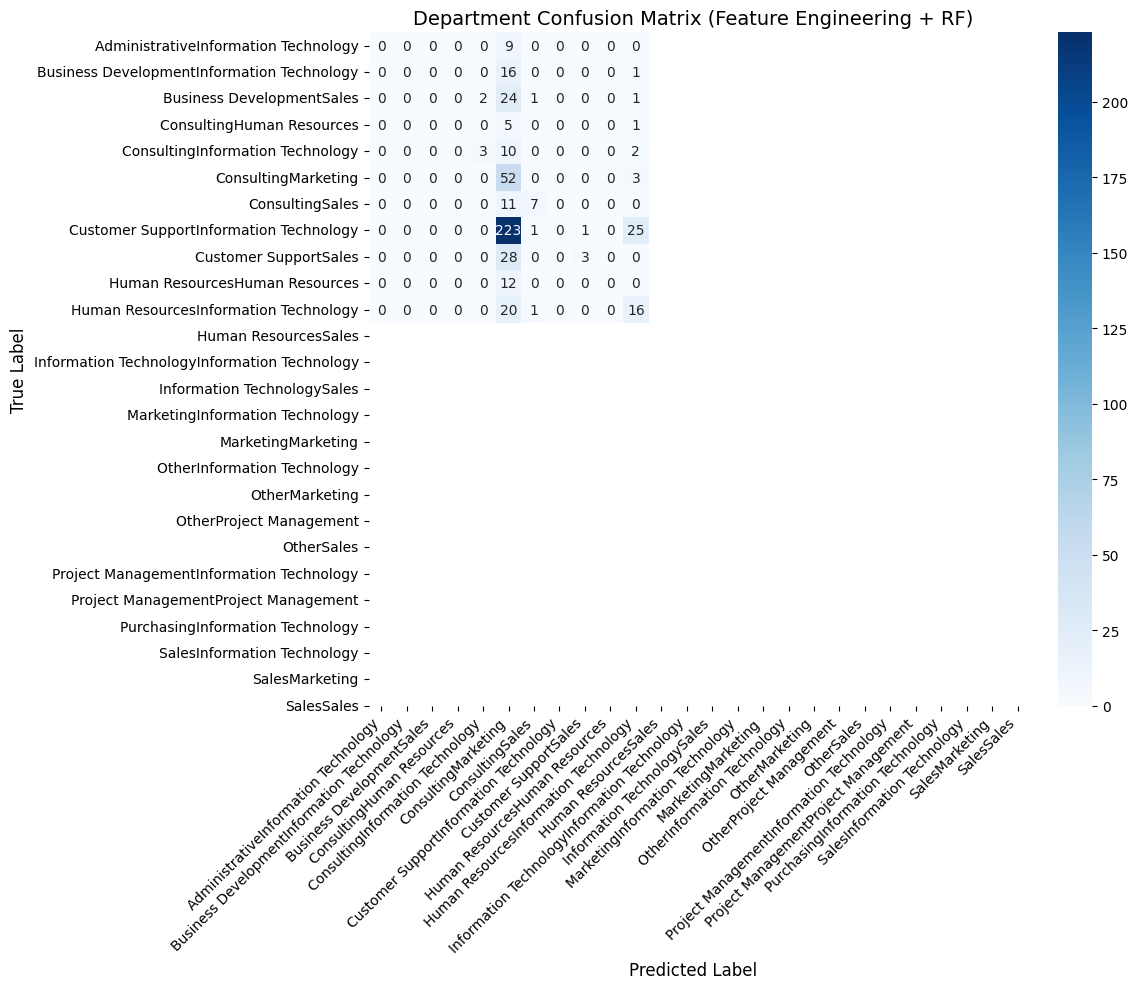

In [22]:
# Department confusion matrix
dept_cm = confusion_matrix(dept_y_val, dept_predictions)
dept_labels = sorted(set(dept_y_val + dept_predictions))

plt.figure(figsize=(12, 10))
sns.heatmap(dept_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels, yticklabels=dept_labels)
plt.title('Department Confusion Matrix (Feature Engineering + RF)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

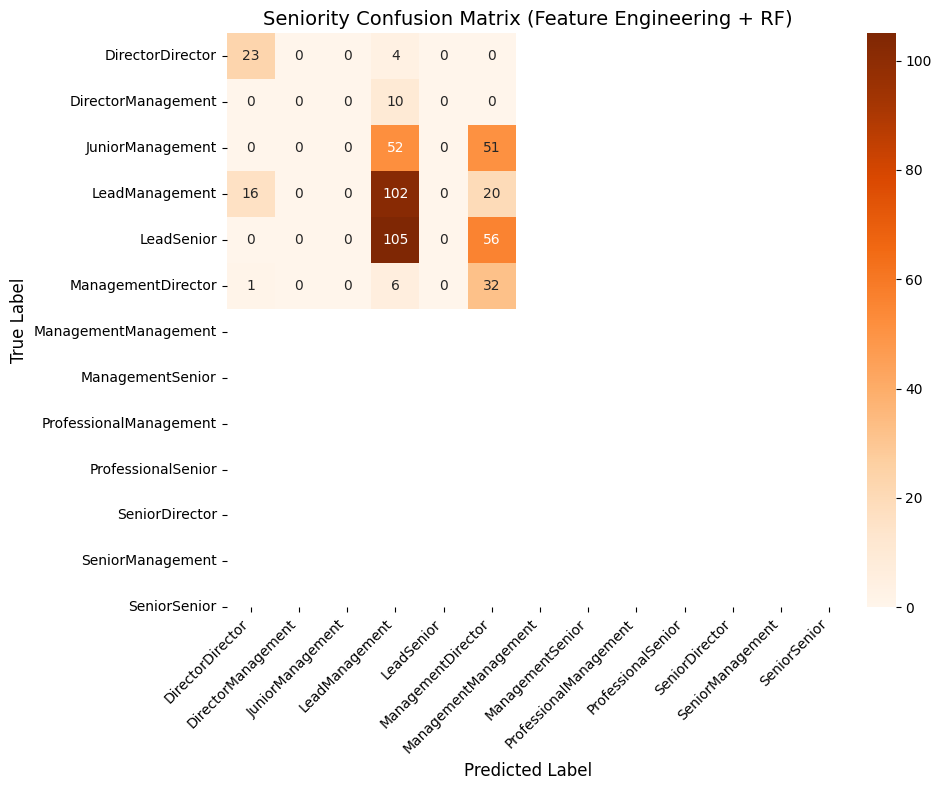

In [23]:
# Seniority confusion matrix
sen_cm = confusion_matrix(sen_y_val, sen_predictions)
sen_labels = sorted(set(sen_y_val + sen_predictions))

plt.figure(figsize=(10, 8))
sns.heatmap(sen_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels, yticklabels=sen_labels)
plt.title('Seniority Confusion Matrix (Feature Engineering + RF)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 12. Save Results

In [24]:
# Per-class F1 scores
dept_report = classification_report(dept_y_val, dept_predictions, output_dict=True, zero_division=0)
dept_f1_scores = {label: metrics['f1-score'] for label, metrics in dept_report.items() 
                  if label not in ['accuracy', 'macro avg', 'weighted avg']}

sen_report = classification_report(sen_y_val, sen_predictions, output_dict=True, zero_division=0)
sen_f1_scores = {label: metrics['f1-score'] for label, metrics in sen_report.items() 
                 if label not in ['accuracy', 'macro avg', 'weighted avg']}

# Prepare results dictionary
results = {
    "approach": "Feature Engineering + Random Forest",
    "department": {
        "accuracy": float(dept_accuracy),
        "precision": float(dept_precision),
        "recall": float(dept_recall),
        "f1_macro": float(dept_f1),
        "f1_weighted": float(dept_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in dept_f1_scores.items()}
    },
    "seniority": {
        "accuracy": float(sen_accuracy),
        "precision": float(sen_precision),
        "recall": float(sen_recall),
        "f1_macro": float(sen_f1),
        "f1_weighted": float(sen_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in sen_f1_scores.items()}
    },
    "metadata": {
        "training_data": "unannotated_cvs (with lookup table labels)",
        "validation_data": "annotated_cvs",
        "training_samples_dept": int(dept_X_train.shape[0]),
        "training_samples_sen": int(sen_X_train.shape[0]),
        "validation_samples_dept": int(len(dept_y_val)),
        "validation_samples_sen": int(len(sen_y_val)),
        "career_features": train_career_features.shape[1],
        "tfidf_features": train_tfidf_features.shape[1],
        "total_features": train_combined_features.shape[1],
        "n_estimators": 100,
        "max_depth": 20
    },
    "timestamp": datetime.now().isoformat()
}

# Save to JSON
output_path = RESULTS_DIR / 'feature_engineering_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {output_path}")
print(f"\n📊 Summary:")
print(f"  Department - Accuracy: {dept_accuracy:.4f}, F1 (macro): {dept_f1:.4f}")
print(f"  Seniority  - Accuracy: {sen_accuracy:.4f}, F1 (macro): {sen_f1:.4f}")


✅ Results saved to: results\feature_engineering_results.json

📊 Summary:
  Department - Accuracy: 0.1695, F1 (macro): 0.1425
  Seniority  - Accuracy: 0.3285, F1 (macro): 0.2498


---

## Summary

### Approach
- ✅ **Training**: Unannotated CVs with labels from lookup tables (fuzzy matching)
- ✅ **Features**: Career history (number of jobs) + TF-IDF from titles
- ✅ **Model**: Random Forest (handles non-linear patterns)
- ✅ **Validation**: Annotated CVs (separate dataset)

### Strengths
- ✅ Uses career history features (e.g., number of previous jobs)
- ✅ Self-contained (doesn't rely on other model outputs)
- ✅ Random Forest handles non-linear patterns well
- ✅ Feature importance provides interpretability
- ✅ Fast training and inference

### Limitations
- ⚠️ Training labels depend on lookup table coverage
- ⚠️ Validation data lacks career history features (set to default)
- ⚠️ Hand-crafted features need domain knowledge
- ⚠️ May not generalize to other datasets

### Key Insights
- Check feature importance to see if career features (e.g., `num_previous_jobs`) matter
- Compare with other approaches in final comparison notebook
- Career history features may be powerful predictors for seniority